## An updated investigation into the HRC Byte Shift Anomaly

Dan Patnaude & Grant Tremblay | January 2019


This notebook uses a setup that (for now) is specific to Grant Tremblay's machines. See him if you need help running this on your machine. 

In [9]:
import os

import datetime as dt

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import dates

import numpy as np
from scipy.interpolate import spline
from scipy.interpolate import interp1d
from scipy.signal import hilbert

try:
    from hrcsentinel import hrccore as hrc
except ImportError:
    raise ImportError(
        "hrcsentinel required. Download here: \
        https://github.com/granttremblay/HRCsentinel")

In [10]:
import datetime

#### Working Directories:

In [29]:
home_directory = os.path.expanduser("~")
msid_directory = home_directory + "/Dropbox/Work/HRCOps/MSIDCloud/"

figure_save_directory = home_directory + "/HRCOps/Projects/HRCSSC/figures/"

# Make that directory if it doesn't exist
if not os.path.exists(figure_save_directory):
    os.mkdir(figure_save_directory)
    print("Made directory {}".format(figure_save_directory))

#### Preferences

In [30]:
rasterized = True

Full resolution (e.g. unbinned) MSIDs we (might) care about: 

In [31]:

msids = [
    "2FE00ATM",  # Front-end Temperature (c)
    "2LVPLATM",  # LVPS Plate Temperature (c)
    "2IMHVATM",  # Imaging Det HVPS Temperature (c)
    "2IMINATM",  # Imaging Det Temperature (c)
    "2SPHVATM",  # Spectroscopy Det HVPS Temperature (c)
    "2SPINATM",  # Spectroscopy Det Temperature (c)
    "2PMT1T"  ,  # PMT 1 EED Temperature (c)
    "2PMT2T"  ,  # PMT 2 EED Temperature (c)
    "2DCENTRT",  # Outdet2 EED Temperature (c)
    "2FHTRMZT",  # FEABox EED Temperature (c)
    "2CHTRPZT",  # CEABox EED Temperature (c)
    "2FRADPYT",  # +Y EED Temperature (c)
    "2CEAHVPT",  # -Y EED Temperature (c)
    "2CONDMXT",  # Conduit Temperature (c)
    "2UVLSPXT",  # Snout Temperature (c)
    "2CE00ATM",  # CEA Temperature 1 (c) THESE HAVE FEWER POINTS AS THEY WERE RECENTLY ADDED BY TOM
    "2CE01ATM",  # CEA Temperature 2 (c) THESE HAVE FEWER POINTS AS THEY WERE RECENTLY ADDED BY TOM
    "2FEPRATM",  # FEA PreAmp (c)
    "2SMTRATM",  # Selected Motor Temperature (c) THIS IS ALWAYS 5 DEGREES THROUGHOUT ENTIRE MISSION
    "2DTSTATT"   # OutDet1 Temperature (c)
]

Read in those MSIDs:

In [32]:
data = {}
binning = "full"
valtype = "vals"
timeperiod = "pastyear"

for msidname in msids:
    print("Reading {} {} for {}".format(binning, valtype.upper(), msidname))
    times, values = hrc.parse_generic_msid(msid_directory + "{}".format(msidname) + "_{}_{}.csv".format(binning, timeperiod), valtype)
    #_, stds = hrc.parse_generic_msid(msid_directory + "{}".format(msidname) + "_{}_{}.csv".format(binning, timeperiod), "stds")
    data["{}_times".format(msidname)] = times
    data["{}_values".format(msidname)] = values
    #data["{}_stds".format(msidname)] = stds

Reading full VALS for 2FE00ATM
Reading full VALS for 2LVPLATM
Reading full VALS for 2IMHVATM
Reading full VALS for 2IMINATM
Reading full VALS for 2SPHVATM
Reading full VALS for 2SPINATM
Reading full VALS for 2PMT1T
Reading full VALS for 2PMT2T
Reading full VALS for 2DCENTRT
Reading full VALS for 2FHTRMZT
Reading full VALS for 2CHTRPZT
Reading full VALS for 2FRADPYT
Reading full VALS for 2CEAHVPT
Reading full VALS for 2CONDMXT
Reading full VALS for 2UVLSPXT
Reading full VALS for 2CE00ATM
Reading full VALS for 2CE01ATM
Reading full VALS for 2FEPRATM
Reading full VALS for 2SMTRATM
Reading full VALS for 2DTSTATT


You can make a quicklook plot like this: 

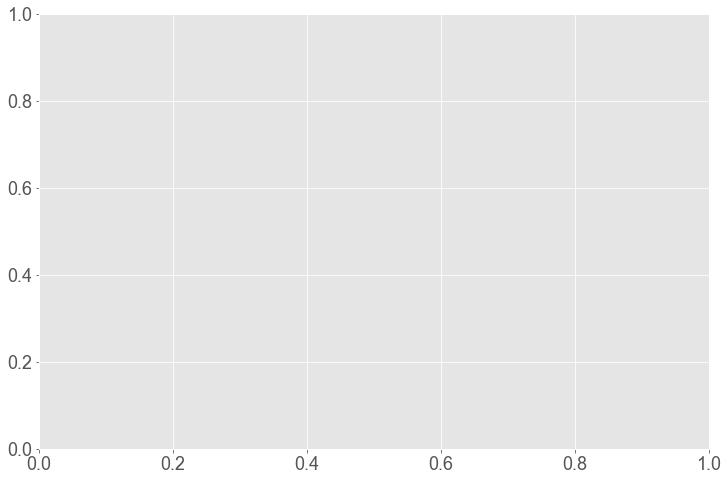

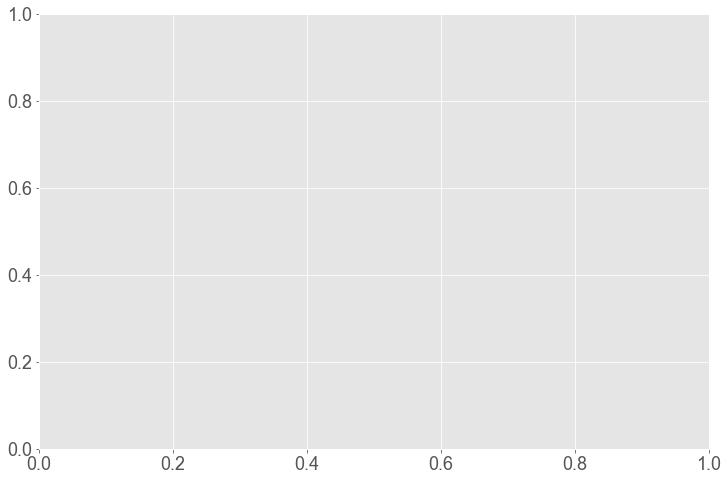

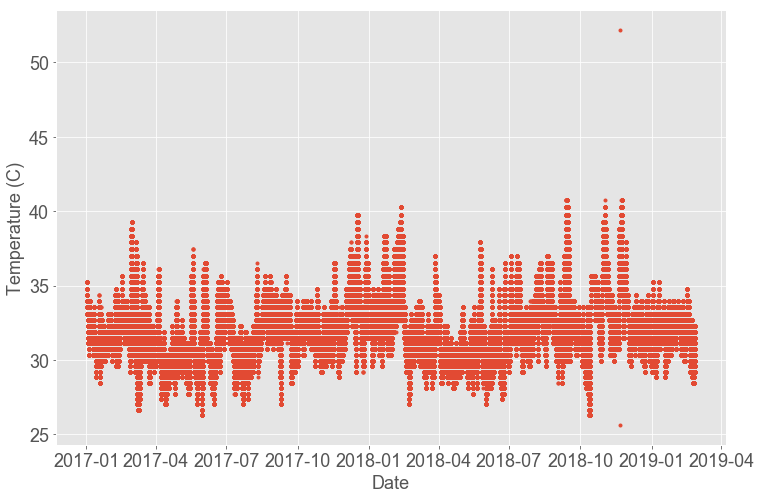

In [33]:
msid = "2SPHVATM"

outfile = figure_save_directory + '{}.pdf'.format(msid)
hrc.dateplot(data['{}_times'.format(msid)], data['{}_values'.format(msid)], ylabel="Temperature (C)", markersize=3.0, save=False, filename=outfile)

You can compute 30 day means and write it to a sortable table like this:



In [34]:
ave_table = Table()

all_names = []
all_means = []
all_stds = []


for msidname in msids:
    daybin = 100 # number of days over which to average the daily averages
    mean = np.mean(data["{}_values".format(msidname)][-daybin:]).round(2)
    std = np.std(data["{}_values".format(msidname)][-daybin:]).round(2)
    
    all_names.append(msidname)
    all_means.append(mean)
    all_stds.append(std)
    
ave_table["MSIDName"] = all_names
ave_table["Average".format(daybin)] = all_means
ave_table["STD"] = all_stds

Sort the table in ascending order by Average temperature, so that we can make a pretty sequential plot later


In [35]:
ave_table.sort("Average")
ave_table

MSIDName,Average,STD
str8,float64,float64
2SMTRATM,5.83,0.13
2UVLSPXT,16.66,0.0
2IMINATM,19.6,0.0
2FRADPYT,20.12,0.19
2DCENTRT,20.19,0.0
2SPINATM,20.97,0.0
2CE00ATM,21.39,0.0
2CE01ATM,21.7,0.0
2DTSTATT,22.35,0.0


Now create a REORDERED list of MSID names, ordered by increasing average temperature, in order to make pretty sequential color cycles

In [36]:
ordered_msidlist = ave_table["MSIDName"]

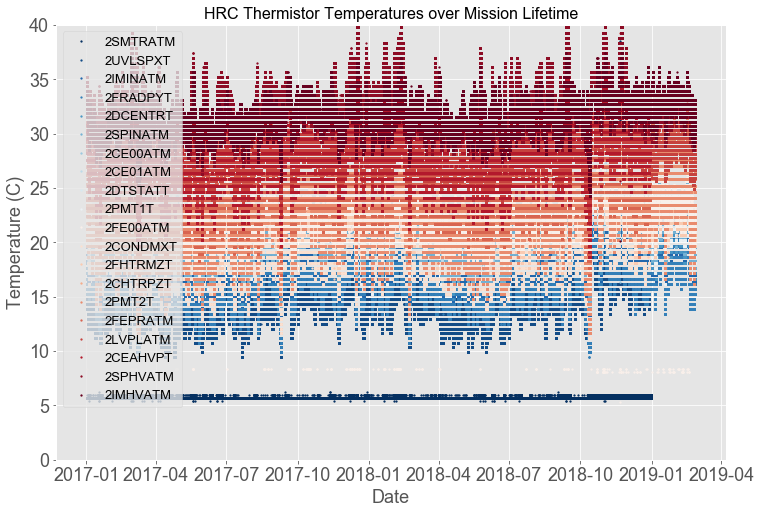

In [37]:
figure_savename = figure_save_directory + "all_msids_figure.pdf"
rasterized = True # Make this True to ensure the file size is small. Otherwise you're plotting thousands of vector points. 

fig, ax = plt.subplots(figsize=(12, 8))

n_lines = len(ordered_msidlist)
color_idx = np.linspace(0, 1, n_lines)


for i, msidname in zip(color_idx, ordered_msidlist):
    ax.plot_date(data["{}_times".format(msidname)],
                 data["{}_values".format(msidname)], '.', alpha=1.0, markersize=2.5, label='{}'.format(msidname), color=plt.cm.RdBu_r(i), rasterized=rasterized)
    ax.set_ylabel('Temperature (C)')
    ax.set_xlabel('Date')
    ax.set_ylim(0, 40)
    
    ax.set_title("HRC Thermistor Temperatures over Mission Lifetime")
    #ax.legend()
    #ax.set_ylim(10, 40)


ax.legend(loc=2, prop={'size': 13})
    
plt.show()

fig.savefig(figure_savename, dpi=300)

In [38]:
data["2PMT2T"]

KeyError: '2PMT2T'

Read in ```HRC_SS_HK_BAD``` pseudoMSID. Make it into an ```astropy``` for easier access

In [ ]:
ssc_events = {}

ssc_flags_file = msid_directory + "HRC_SS_HK_BAD_full_pastfiveyears.csv"
ssc_times, ssc_flags = hrc.parse_generic_msid(ssc_flags_file, valtype="vals")

ssc_events['SSC_times'] = ssc_times
ssc_events['SSC_flags'] = ssc_flags

ssc_events_table = Table(ssc_events)


Invalid HRC SS and HK telemetry can arise in three ways:

1. When telemetry format changes there is commanding to change the timing signals used to fill the housekeeping and secondary science rates that can result in invalid data being put in these MSIDs for up to a major frame.

2. When detectors change or a detector is set to its default configuration the FIFO used to hold the housekeeping an secondary science data gets reset which may result in a single bad sample of data.

3. The secondary-science byte-shift anomaly causes the occasional portion of the housekeeping and sometimes the rate data to be corrupted.
In the Ska archive the presence of these conditions is tracked in a new pseudo-MSID called HRC_SS_HK_BAD.

The first two of these are detected by looking at “spare” bits in the MSID ```SCIDPREN```. The third condition, which is what we're interested in, is detected by its impact on the MSID ```2SMTRATM```. If it is less than -20degC or greater than 50degC then the analog housekeeping from the row is marked with bad quality. In this case the ```HRC_SS_HK_BAD``` MSID has bit 10 set, which can be detected by a logical-and with ```0x0400 (1024)```.

We can therefore count the number of byte-shift anomaly instances over the past three years by creating a simple mask from our ```ssc_events_table```:

In [ ]:
byte_shift_mask = ssc_events_table['SSC_flags'] == 1024

print("There are {} byte shift anomaly events over the past three years.".format(sum(byte_shift_mask)))

In [ ]:
byte_shift_times = ssc_events_table[byte_shift_mask]['SSC_times']

It is now easy to plot every flagged instance of an HRC byte shift 

In [ ]:
figure_savename = figure_save_directory + "all_msids_figure_with_ssc.pdf"
rasterized = True # Make this True to ensure the file size is small. Otherwise you're plotting thousands of vector points. 

fig, ax = plt.subplots(figsize=(12, 8))

n_lines = len(ordered_msidlist)
color_idx = np.linspace(0, 1, n_lines)


for byte_shift_time in byte_shift_times:
    ax.axvline(byte_shift_time, lw=0.5, color=ssccolor, alpha=0.3, rasterized=rasterized)
    

for i, msidname in zip(color_idx, ordered_msidlist):
    ax.plot_date(data["{}_times".format(msidname)],
                 data["{}_values".format(msidname)], '.', alpha=1.0, markersize=2.5, label='{}'.format(msidname), color=plt.cm.RdBu_r(i), rasterized=rasterized)
    
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Date')
ax.set_ylim(0, 40)
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2019, 2, 1)])


ax.set_title("HRC Thermistor Temperatures over Mission Lifetime")
#ax.legend()
#ax.set_ylim(10, 40)


ax.legend(loc=2, prop={'size': 13})
    
plt.show()

fig.savefig(figure_savename, dpi=300)

In [ ]:
data_full = {}
binning = "full"
valtype = "vals"
timeperiod = "pastyear"

for msidname in msids:
    print("Reading {} {} for {}".format(binning, valtype.upper(), msidname))
    times, values = hrc.parse_generic_msid(msid_directory + "{}".format(msidname) + "_{}_{}.csv".format(binning, timeperiod), valtype)
    #_, stds = hrc.parse_generic_msid(msid_directory + "{}".format(msidname) + "_{}_{}.csv".format(binning, timeperiod), "stds")
    data_full["{}_times".format(msidname)] = times
    data_full["{}_values".format(msidname)] = values
    #data["{}_stds".format(msidname)] = stds

In [ ]:
figure_savename = figure_save_directory + "fullres_with_ssc_full.pdf"
rasterized = True # Make this True to ensure the file size is small. Otherwise you're plotting thousands of vector points. 

fig, ax = plt.subplots(figsize=(12, 8))

n_lines = len(ordered_msidlist)
color_idx = np.linspace(0, 1, n_lines)


for byte_shift_time in byte_shift_times:
    ax.axvline(byte_shift_time, lw=0.5, color=ssccolor, alpha=0.3, rasterized=rasterized)
    

for i, msidname in zip(color_idx, ordered_msidlist):
    ax.plot_date(data_full["{}_times".format(msidname)],
                 data_full["{}_values".format(msidname)], '.', alpha=1.0, markersize=2.5, label='{}'.format(msidname), color=plt.cm.Spectral_r(i), rasterized=rasterized)
    
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Date')
ax.set_ylim(0, 40)
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2019, 2, 1)])


ax.set_title("HRC Thermistor Temperatures over Mission Lifetime")
#ax.legend()
#ax.set_ylim(10, 40)


ax.legend(loc=2, prop={'size': 13})
    
plt.show()

fig.savefig(figure_savename, dpi=100)

In [ ]:

def getBadTemps(Temp, Tmin, Tmax):
    """Interpolated temperatures for times of corrupted secondary science.
    """
    print("Number initially flagged as corrupt:", sum(Temp.bads))
    Tbad = []
    # Temperature estimates for bad data
    nTemp = len(Temp.vals)
    for i in xrange(nTemp):
        # MSID values outside [Tmin, Tmax] are also assumed to be bad
        if Temp.vals[i] < Tmin or Temp.vals[i] > Tmax:
            Temp.bads[i] = True
        if Temp.bads[i]:
            # Interpolate the temperature from good bracketing values
            ibelow = i - 1
            while ibelow >= 0 and Temp.bads[ibelow]:
                ibelow -= 1
            iabove = i + 1
            while iabove < nTemp and Temp.bads[iabove]:
                iabove += 1
            if ibelow < 0:
                Tinterp = Temp.vals[iabove]
            elif iabove >= nTemp:
                Tinterp = Temp.vals[ibelo]
            else:
                Tinterp = ((iabove - i) * Temp.vals[ibelow] + (i - ibelow)
                           * Temp.vals[iabove]) / (iabove - ibelow)
            Tbad.append(Tinterp)

    # Sanity checks
    nbad = sum(Temp.bads)
    print("Total number of samples:", nTemp)
    print("Number of temperatures flagged as bad:", nbad)
    print("len (Tbad) =", len(Tbad))
    print("Overall fraction of bad temperatures:", nbad / float(nTemp))

    return Tbad


def goodHist(Temp):
    """Make a histogram of good temperatures and plot it as the
    distribution of fractions.
    """
    # Good temperatures
    Tgood = [x for x, y in zip(Temp.vals, Temp.bads) if not y]
    # Counts of good temperatures
    Tgcount = dict()
    for x in Tgood:
        if x in Tgcount:
            Tgcount[x] += 1
        else:
            Tgcount[x] = 1

    # Make normalized histogram of the good temperatures.
    # The ordered list of discrete temperature values
    Tval = sorted(Tgcount.keys())
    print("Number of distinct temperatures:", len(Tval))
    print("T values:", Tval)
    # For plotting
    Tgpl = np.array(Tval, dtype)
    norm = 1.0 / float(len(Tgood))
    # Counts for good temperatures as a list ordered by temperature
    Tgcl = [Tgcount[T] for T in Tval]
    fgood = np.array([c * norm for c in Tgcl], dtype)
    # These errors are generally negligible
    fgerr = np.array([math.sqrt(c) * norm for c in Tgcl], dtype)
    plt.errorbar(Tgpl, fgood, yerr=fgerr, fmt='bo')
    return Tval, Tgpl, Tgcl


def badHist(Tbad, Tval, Tgpl, Tgcl):
    """Make histogram of temperatures for corrupted secondary science
    and plot it.
    Tbad = the list of temperatures for corrupted SS
    Tval = ordered list of discrete (good) temperatures seen
    Tgpl = Tval as a numpy array
    Tgcl = counts of good temperatures corresponding to Tval
    """
    # Assemble counts of bad temperatures, binned to Tval
    nval = len(Tval)
    # Temperature cuts are not evenly spaced
    Tcuts = [0.5 * (Tval[i] + Tval[i + 1]) for i in range(nval - 1)]
    Tbcount = [0] * nval
    for T in Tbad:
        if T < Tcuts[0]:
            Tbcount[0] += 1
        elif T >= Tcuts[-1]:
            Tbcount[-1] += 1
        else:
            ilo = 0
            ihi = nval - 2
            while ihi > ilo + 1:
                i = (ilo + ihi) // 2
                if T < Tcuts[i]:
                    ihi = i
                else:
                    ilo = i
            Tbcount[ihi] += 1

    # Simple check that the extreme bins are not over-populated
    if Tbcount[0] > Tbcount[1]:
        print("****Lower MSID limit too high?****:", Tbcount[0], Tbcount[1])
    if Tbcount[-1] > Tbcount[-2]:
        print("****Upper MSID limit too low?****:", Tbcount[-1], Tbcount[-2])
    # Determine count fractions and probabilities, with errors
    bnorm = 1.0 / float(len(Tbad))
    # Gaussian 1 sigma confidence level
    q = 2.0 * norm.cdf(1.0) - 1.0
    fbl = []  # Bad fraction
    fbel = []  # Error on bad fraction
    prob = []  # Probability of being bad at this temperature
    pe = []  # Error in the probability
    for i in range(nval):
        bad = Tbcount[i]
        good = Tgcl[i]
        fbl.append(bad * bnorm)
        prob.append(bad / float(bad + good))
        if bad != 0:
            # Poisson error estimate for bad count > 0.
            err = math.sqrt(bad)
            fbel.append(bnorm * err)
            # The number of samples for this temperature is assumed fixed,
            # which hardly makes a difference when good >> bad
            pe.append(err / (bad + good))
        else:
            # When there are no bad temperatures, use the 1 sigma upper
            # limit on probability of being bad.  This is the binomial
            # result, but it is close to Poission unless the total number
            # of samples is small.
            pup = 1.0 - (1.0 - q)**(1.0 / float(good))
            fbel.append(pup * good * bnorm)
            pe.append(pup)
            print("Upper limit: T =", Tval[i], "; p =", pup, "; n =", good, "; n p =", good * pup)

    fbad = np.array(fbl, dtype)
    fberr = np.array(fbel, dtype)
    plt.errorbar(Tgpl, fbad, yerr=fberr, fmt='ro')
    # Force lower limit to zero
    ylims = plt.ylim()
    plt.ylim([0.0, ylims[1]])
    plt.xlabel(r'$T\ (\rm C)$')
    plt.ylabel("fraction")
    return prob, pe


In [ ]:
Tmin = 15.0
Tmax = 35.0

In [ ]:
Temp = data_full["2FE00ATM_values"]
Tbad = getBadTemps(Temp, Tmin, Tmax)